In [1]:
#在 TensorFlow 中使用 LinearRegressor 类并基于单个输入特征预测各城市街区的房屋价值中位数


In [62]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [4]:
# load dataset
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [5]:
#对数据进行随机化处理
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3701,-117.9,34.1,35.0,1891.0,353.0,1093.0,382.0,4.0,165.5
2306,-117.5,34.1,6.0,5571.0,1316.0,4048.0,1154.0,2.0,91.1
16450,-122.6,38.9,16.0,1657.0,390.0,572.0,301.0,1.5,62.0
14859,-122.2,37.8,52.0,2927.0,402.0,1021.0,380.0,8.2,390.1
14097,-122.1,37.6,33.0,1160.0,252.0,729.0,220.0,3.8,146.1
...,...,...,...,...,...,...,...,...,...
15470,-122.3,37.5,52.0,900.0,183.0,371.0,166.0,3.2,296.4
7627,-118.4,34.1,52.0,1608.0,289.0,630.0,252.0,5.6,500.0
5922,-118.2,34.1,52.0,1590.0,360.0,1127.0,321.0,3.5,173.9
15404,-122.3,37.9,40.0,2866.0,617.0,1305.0,589.0,3.6,209.1


In [6]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [42]:
# 1、定义特征并配置特征列

my_feature = california_housing_dataframe[["total_rooms"]]

# 在 TensorFlow 中，我们使用一种称为“特征列”的结构来表示特征的数据类型。
# 特征列仅存储对特征数据的描述；不包含特征数据本身
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

my_feature

,total_rooms
3701,1891.0
2306,5571.0
16450,1657.0
14859,2927.0
14097,1160.0
...,...
15470,900.0
7627,1608.0
5922,1590.0
15404,2866.0


In [43]:
# 2、定义目标

targets = california_housing_dataframe["median_house_value"]
targets

3701    165.5
2306     91.1
16450    62.0
14859   390.1
14097   146.1
         ... 
15470   296.4
7627    500.0
5922    173.9
15404   209.1
4063    260.9
Name: median_house_value, dtype: float64

In [52]:
# 3、配置LinearRegressor

#我们还会通过 clip_gradients_by_norm 将梯度裁剪应用到我们的优化器。梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)



In [61]:
# 4、定义输入函数
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    """
    首先，我们将 Pandas 特征数据转换成 NumPy 数组字典。
    然后，我们可以使用 TensorFlow Dataset API 根据我们的数据构建 Dataset 对象，
    并将数据拆分成大小为 batch_size 的多批数据，以按照指定周期数 (num_epochs) 进行重复。
    
    """
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}  
    # features {'total_rooms': array([1891., 5571., 1657., ..., 1590., 2866., 3653.])}
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # 最后，输入函数会为该数据集构建一个迭代器，并向 LinearRegressor 返回下一批数据
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [63]:
# 5、训练模型
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [84]:
# 6、评估模型
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print ("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print ("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [85]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print ("Min. Median House Value: %0.3f" % min_house_value)
print ("Max. Median House Value: %0.3f" % max_house_value)
print ("Difference between Min. and Max.: %0.3f" % min_max_difference)
print ("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [86]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


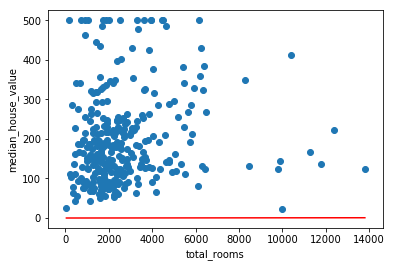

In [87]:
sample = california_housing_dataframe.sample(n=300)
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [ ]:
## 整合所有的过程
# 见1-2